In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()

In [3]:
from azureml.core.model import Model

for model in Model.list(ws):
    print(model.name, model.version)

pytorch-torchvision-mnist 1
pytorch-mnist 4
sklearn_mnist 2


In [4]:
model = Model(ws, name="pytorch-torchvision-mnist", version=1)

In [8]:
from azureml.core import Environment

for env in Environment.list(ws):
    print(env)

cifar10-env
mnist-env
pytorch-env
pytorch-torchvision-env
AzureML-ACPT-pytorch-1.13-py38-cuda11.7-gpu


In [9]:
env = Environment.get(ws, name="pytorch-torchvision-env")

In [10]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1,
                                               memory_gb=1,
                                               tags={"data": "MNIST",
                                                     "method": "pytorch"},
                                                description="Predict MNIST with PyTorch loaded using Torchvision")

In [11]:
import uuid
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig

Inference_config = InferenceConfig(entry_script="score.py",
                                   environment=env)

service_name = "pytorch-torchvision-svc" + str(uuid.uuid4())[:4]
service = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model],
                       inference_config=Inference_config,
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

/tmp/ipykernel_30695/3451241785.py:9: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  service = Model.deploy(workspace=ws,


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2025-01-25 19:15:16+01:00 Creating Container Registry if not exists.
2025-01-25 19:15:16+01:00 Registering the environment.
2025-01-25 19:15:19+01:00 Use the existing image.
2025-01-25 19:15:20+01:00 Generating deployment configuration.
2025-01-25 19:15:21+01:00 Submitting deployment to compute.
2025-01-25 19:15:28+01:00 Checking the status of deployment pytorch-torchvision-svcb547..
2025-01-25 19:18:23+01:00 Checking the status of inference endpoint pytorch-torchvision-svcb547.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [19]:
from azureml.core import Dataset

for dataset in Dataset.get_all(ws):
    print(dataset)

torchvision-mnist-dataset
mnist-opendataset
mnist_opendataset


In [20]:
dataset_name = "torchvision-mnist-dataset"

mnist_dataset = Dataset.get_by_name(ws, name=dataset_name)

In [21]:
dataset_path = mnist_dataset.download(target_path="data", overwrite=True)

{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}


In [22]:
from utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
xtest = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
ytest = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

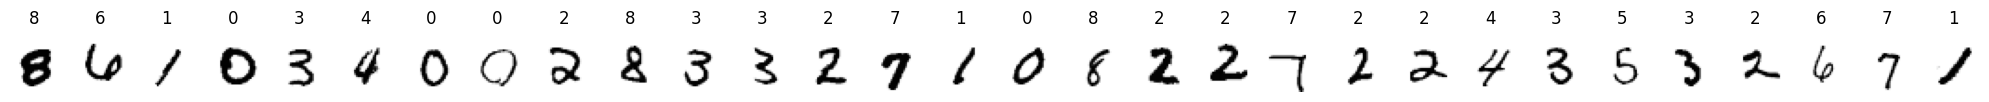

In [28]:
import json
import numpy as np
import matplotlib.pyplot as plt

n = 30
sample_indices = np.random.permutation(xtest.shape[0])[:n]
xtest_samples = xtest[sample_indices].reshape(n, 1, 28, 28)
# xtest_samples = xtest_samples / 255.0

test_samples = json.dumps({
    "data": xtest_samples.tolist()
})
test_samples = bytes(test_samples, encoding='utf8')

result = service.run(input_data=test_samples)

plt.figure(figsize=(20, 3))  # Adjust figure size for better visualization

for i, s in enumerate(sample_indices):
    plt.subplot(1, n, i + 1)
    plt.axis('off')  # Hide axes for cleaner visualization
    
    # Use different color for misclassified samples
    font_color = 'red' if ytest[s] != result[i] else 'black'
    clr_map = plt.cm.gray if ytest[s] != result[i] else plt.cm.Greys
    
    # Display the predicted value
    plt.text(x=10, y=-10, s=str(result[i]), fontsize=12, color=font_color)
    
    # Display the image
    plt.imshow(xtest[s].reshape(28, 28), cmap=clr_map)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

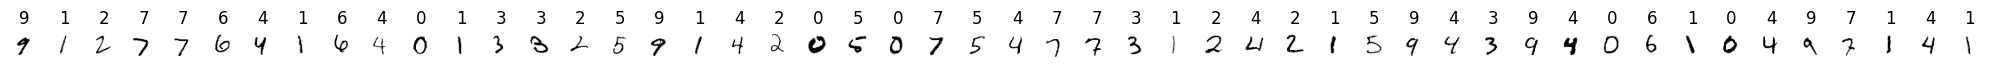

In [32]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

testset = datasets.MNIST(root=data_folder,
                         train=False,
                         download=True,
                         transform=transform)
truncated_size = 50
truncated_testset = torch.utils.data.Subset(testset, range(truncated_size))

testloader = torch.utils.data.DataLoader(truncated_testset,
                                         batch_size=64,
                                         shuffle=True)

images, labels = next(iter(testloader))
input_data = json.dumps({
    "data": images.tolist()
})
input_data = bytes(input_data, encoding='utf8')

result = service.run(input_data=input_data)

plt.figure(figsize=(20, 3))
for i in range(truncated_size):
    plt.subplot(1, truncated_size, i + 1)
    plt.axis('off')
    
    font_color = 'red' if labels[i].item() != result[i] else 'black'
    clr_map = plt.cm.gray if labels[i].item() != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=str(result[i]), fontsize=12, color=font_color)
    plt.imshow(images[i].reshape(28, 28), cmap=clr_map)
plt.tight_layout()
plt.show()

In [36]:
import torch
from torchvision import datasets, transforms
import json
import numpy as np

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the test dataset
testset = datasets.MNIST(root=data_folder,
                         train=False,
                         download=True,
                         transform=transform)

# Create a DataLoader for the test dataset
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=64,
                                         shuffle=False)  # Do not shuffle for evaluation

# Initialize variables to store predictions and labels
all_predictions = []
all_labels = []

# Iterate through the testloader
for images, labels in testloader:
    # Prepare the input data for the service
    input_data = json.dumps({
        "data": images.tolist()  # Convert tensor to list
    })
    input_data = bytes(input_data, encoding='utf8')  # Convert to bytes

    # Run inference on the service
    result = service.run(input_data=input_data)

    # Collect predictions and labels
    all_predictions.extend(result)
    all_labels.extend(labels.tolist())

# Convert predictions and labels to NumPy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
correct_predictions = (all_predictions == all_labels).sum()
total_samples = len(all_labels)
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.01%


In [37]:
service.delete()

Running
2025-01-25 19:45:43+01:00 Check and wait for operation (b394ae80-e349-44a1-949e-cc7e4c342fa0) to finish.
2025-01-25 19:45:47+01:00 Deleting service entity.
Succeeded
